In [1]:
import os
os.chdir('/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA')
from pcmf import path_plot, plot_cluster_assignments, two_cluster_data, pcmf_full
from p3ca import cluster_metrics, calculate_scores_nonpath
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import multivariate_normal
from collections import OrderedDict

import time
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment as linear_assignment
import seaborn as sns; sns.set()
import numpy as np
os.chdir('/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA/utils/subspace-clustering-master')
from cluster.selfrepresentation import ElasticNetSubspaceClustering


os.chdir('/Users/amandabuch/Documents/clusterCCA/revision1/clusterCCA')
from pcmf import sparse_D, get_weights
from pcmf import cluster_path, select_fit, cluster_fit

from pcmf import pcmf_full, pcmf_approx_uV, pcmf_full_consensus, save_multi_image, two_cluster_data, generate_cluster_PMD_data

from sklearn.utils.extmath import randomized_svd

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

import cvxpy as cp



In [33]:
def generate_data(n_clusters=5, m=10, num_vars=100, hstack_ones=True, r=1):
    #
    print('run: '+str(r))
    means=[-1.5, 1.5, -1.0, 1.0, -0.4]
    ms = [m,m,m,m,m]
    sigma=0.075
    density=0.5
    #
    # Get clustered CCA data
    X_clusters, u_true, v_true, _ = generate_cluster_PMD_data(ms, num_vars, sigma, density, n_clusters, means=means) 
    X_c=np.vstack(X_clusters)
    true_clusters=np.repeat(np.arange(n_clusters),m)
    np.random.seed(seed=r)
    idx_perm=np.random.permutation(X_c.shape[0])
    X_all=X_c[idx_perm,:]
    true_clusters_all=true_clusters[idx_perm]
    #
    if hstack_ones==True:
        X_all = np.hstack( (X_all, np.ones((X_all.shape[0],1))) )
    #
    return X_all, true_clusters_all

def pcmf_full_consensus_byrank(X_all, penalty_list, split_size=0, fontsize=16, max_problem_rank=5, rho=1.0, admm_iters=10, weights='Gaussian', gauss_coef=2.0, neighbors=10, print_progress=True, parallel=False, output_file='nan'):
    As = []
    Us = []
    Ss = []
    Vs = []
    As_its = []
    if split_size==0:
        split_size =X_all.shape[0]
    #
    for problem_rank in range(1,max_problem_rank):
        tic=time.time()
        A, U, S, V = pcmf_full_consensus(X_all, penalty_list, split_size=split_size, rho=rho, admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, problem_rank=problem_rank, neighbors=neighbors, print_progress=True, parallel=parallel, output_file=save_path+'.txt')
        As.append(A)
        Us.append(U)
        Ss.append(S)
        Vs.append(V)
        toc=time.time() - tic
    return As, Us, Ss, Vs
    #
def plot_variance_byrank(Ss,n_infinities,penalty_list,fontsize=16):
    import matplotlib 
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor('white')
    plt.xlabel('Problem Rank (r)',fontsize=fontsize)
    plt.ylabel('Total Variance Explained ($\Sigma$s)',fontsize=fontsize)
    plt.grid(b=None)
    colors = cm.rainbow(np.linspace(1, 0, len(penalty_list)-n_infinities))
    c = 0
    for k in np.arange(n_infinities,len(penalty_list),1):
        P = []
        for S in Ss:
            P.append( np.sum(S[k][1:len(S[k])]) )
        #
        plt.plot(np.arange(1,len(Ss)+1),P,'o-',color=colors[c,:])
        c = c + 1
    plt.xticks(fontsize=fontsize,rotation=0)
    plt.yticks(fontsize=fontsize,rotation=0)
    
    mymap = matplotlib.colors.LinearSegmentedColormap.from_list('colors',colors)
    sm = plt.cm.ScalarMappable(cmap=mymap, norm=plt.Normalize(vmin=n_infinities, vmax=len(penalty_list)-n_infinities ))
    cbar = plt.colorbar(sm)
    cbar.ax.set_title('$\lambda$ idx', rotation=0, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)


def run_byrank(n_clusters=5, m=10, num_vars=100, hstack_ones=True, r=1, max_problem_rank = 5, split_size=0, weights = 'Gaussian', gauss_coef = 5.0, neighbors = 25, rho = 1.0, admm_iters = 5):
    # Generate data
    X_all, true_clusters_all = generate_data(n_clusters=5, m=10, num_vars=100, hstack_ones=True, r=1)
    # PCMF problem parameters
    pcmf_type = 'pcmf_admm'; parallel = False; save_path = 'nan'
    n_infinities = 2; penalty_list = np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-10,10,50))[::-1]), axis=0)
    # Calculate PCMF ADMM model for each problem rank
    As, Us, Ss, Vs = pcmf_full_consensus_byrank(X_all, penalty_list, split_size=split_size, fontsize=16, max_problem_rank=max_problem_rank, rho=rho, admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, neighbors=neighbors, print_progress=print_progress, parallel=parallel, output_file=output_file)
    #
    # Plot total variance explained by all models
    plot_variance_byrank(Ss,n_infinities,penalty_list)
    return X_all, true_clusters_all, As, Us, Ss, Vs



In [13]:
# Generate data
X_all, true_clusters_all = generate_data()
# PCMF problem parameters
pcmf_type = 'pcmf_admm'; parallel = False; print_progress=True; save_path = 'nan'; output_file='nan'
weights = 'Gaussian'; gauss_coef = 5.0; neighbors = 25; rho = 1.0; admm_iters = 5
n_infinities = 2; penalty_list = np.concatenate((np.repeat(np.inf,n_infinities), np.exp(np.linspace(-10,10,50))[::-1]), axis=0)
max_problem_rank = 5
# Calculate PCMF ADMM model for each problem rank
As, Us, Ss, Vs = pcmf_full_consensus_byrank(X_all, penalty_list, split_size=0, fontsize=16, max_problem_rank=max_problem_rank, rho=rho, admm_iters=admm_iters, weights=weights, gauss_coef=gauss_coef, neighbors=neighbors, print_progress=print_progress, parallel=parallel, output_file=output_file)


run: 1
weights: Gaussian neighbors: 25 gauss_coef: 5.0 rho: 1.0
rho1: 1.0 rho2 1.0
Number of batches: 1
Initialize IDX: 0
Means matrix has shape: (50, 101)
[ 1 ] inf...

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[ 2 ] inf...[ 3 ] 2.20265e+04...[ 4 ] 1.46447e+04...[ 5 ] 9.73686e+03...[ 6 ] 6.47375e+03...[ 7 ] 4.30420e+03...[ 8 ] 2.86174e+03...[ 9 ] 1.90268e+03...[ 10 ] 1.26504e+03...[ 11 ] 8.41086e+02...[ 12 ] 5.59213e+02...[ 13 ] 3.71804e+02...[ 14 ] 2.47202e+02...[ 15 ] 1.64357e+02...[ 16 ] 1.09276e+02...[ 17 ] 7.26544e+01...[ 18 ] 4.83058e+01...[ 19 ] 3.21171e+01...[ 20 ] 2.13537e+01...[ 21 ] 1.41974e+01...[ 22 ] 9.43945e+00...[ 23 ] 6.27601e+00...[ 24 ] 4.17273e+00...[ 25 ] 2.77433e+00...[ 26 ] 1.84457e+00...[ 27 ] 1.22640e+00...[ 28 ] 8.15396e-01...[ 29 ] 5.42132e-01...[ 30 ] 3.60448e-01...[ 31 ] 2.39651e-01...[ 32 ] 1.59337e-01...[ 33 ] 1.05938e-01...[ 34 ] 7.04353e-02...[ 35 ] 4.68303e-02...[ 36 ] 3.11361e-02...[ 37 ] 2.07015e-02...[ 38 ] 1.37638e-02...[ 39 ] 9.15113e-03...[ 40 ] 6.08432e-03...[ 41 ] 4.04528e-03...[ 42 ] 2.68959e-03...[ 43 ] 1.78823e-03...[ 44 ] 1.18894e-03...[ 45 ] 7.90490e-04...[ 46 ] 5.25574e-04...[ 47 ] 3.49438e-04...[ 48 ] 2.32331e-04...[ 49 ] 1.54470e-04...[ 50 ] 1

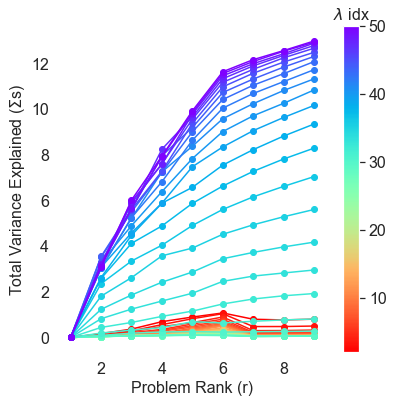

In [32]:
# Run default
X_all, true_clusters_all, As, Us, Ss, Vs = run_byrank()
# plot_variance_byrank(Ss,n_infinities,penalty_list,fontsize=16)

run: 1
weights: Gaussian neighbors: 25 gauss_coef: 5.0 rho: 1.0
rho1: 1.0 rho2 1.0
Number of batches: 2
Initialize IDX: 0
Initialize IDX: 1
Means matrix has shape: (50, 101)
[ 1 ] inf...[ 2 ] inf...[ 3 ] 2.20265e+04...[ 4 ] 1.46447e+04...[ 5 ] 9.73686e+03...[ 6 ] 6.47375e+03...[ 7 ] 4.30420e+03...[ 8 ] 2.86174e+03...[ 9 ] 1.90268e+03...[ 10 ] 1.26504e+03...[ 11 ] 8.41086e+02...[ 12 ] 5.59213e+02...[ 13 ] 3.71804e+02...[ 14 ] 2.47202e+02...[ 15 ] 1.64357e+02...[ 16 ] 1.09276e+02...[ 17 ] 7.26544e+01...[ 18 ] 4.83058e+01...[ 19 ] 3.21171e+01...[ 20 ] 2.13537e+01...[ 21 ] 1.41974e+01...[ 22 ] 9.43945e+00...[ 23 ] 6.27601e+00...[ 24 ] 4.17273e+00...[ 25 ] 2.77433e+00...[ 26 ] 1.84457e+00...[ 27 ] 1.22640e+00...[ 28 ] 8.15396e-01...[ 29 ] 5.42132e-01...[ 30 ] 3.60448e-01...[ 31 ] 2.39651e-01...[ 32 ] 1.59337e-01...[ 33 ] 1.05938e-01...[ 34 ] 7.04353e-02...[ 35 ] 4.68303e-02...[ 36 ] 3.11361e-02...[ 37 ] 2.07015e-02...[ 38 ] 1.37638e-02...[ 39 ] 9.15113e-03...[ 40 ] 6.08432e-03...[ 41 ] 4.04

[ 1 ] inf...[ 2 ] inf...[ 3 ] 2.20265e+04...[ 4 ] 1.46447e+04...[ 5 ] 9.73686e+03...[ 6 ] 6.47375e+03...[ 7 ] 4.30420e+03...[ 8 ] 2.86174e+03...[ 9 ] 1.90268e+03...[ 10 ] 1.26504e+03...[ 11 ] 8.41086e+02...[ 12 ] 5.59213e+02...[ 13 ] 3.71804e+02...[ 14 ] 2.47202e+02...[ 15 ] 1.64357e+02...[ 16 ] 1.09276e+02...[ 17 ] 7.26544e+01...[ 18 ] 4.83058e+01...[ 19 ] 3.21171e+01...[ 20 ] 2.13537e+01...[ 21 ] 1.41974e+01...[ 22 ] 9.43945e+00...[ 23 ] 6.27601e+00...[ 24 ] 4.17273e+00...[ 25 ] 2.77433e+00...[ 26 ] 1.84457e+00...[ 27 ] 1.22640e+00...[ 28 ] 8.15396e-01...[ 29 ] 5.42132e-01...[ 30 ] 3.60448e-01...[ 31 ] 2.39651e-01...[ 32 ] 1.59337e-01...[ 33 ] 1.05938e-01...[ 34 ] 7.04353e-02...[ 35 ] 4.68303e-02...[ 36 ] 3.11361e-02...[ 37 ] 2.07015e-02...[ 38 ] 1.37638e-02...[ 39 ] 9.15113e-03...[ 40 ] 6.08432e-03...[ 41 ] 4.04528e-03...[ 42 ] 2.68959e-03...[ 43 ] 1.78823e-03...[ 44 ] 1.18894e-03...[ 45 ] 7.90490e-04...[ 46 ] 5.25574e-04...[ 47 ] 3.49438e-04...[ 48 ] 2.32331e-04...[ 49 ] 1.54470e-0

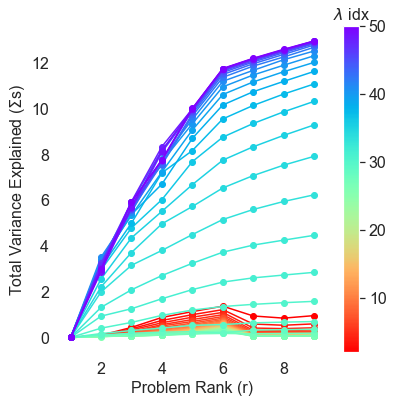

In [35]:
# Run with consensus split, parameters
X_all, true_clusters_all, As, Us, Ss, Vs = run_byrank(n_clusters=5, m=10, split_size=25,num_vars=100, hstack_ones=True, r=1, max_problem_rank = 10, weights = 'Gaussian', gauss_coef = 5.0, neighbors = 25, rho = 1.0, admm_iters = 5)

    
    